In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork

/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
regulation_network = RegulationNetwork()
regulation_network.timestep = 6e-3
regulation_network.realisations = 1

In [3]:
analysis = regulation_network.generate_analysis_object()

In [4]:
for i in range(len(regulation_network.initial_states)):
    print("traj {}".format(i))
    t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
    t.persist()
regulation_network.compute_gradient_derivatives(analysis)

traj 0
traj 1
traj 2
traj 3
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)


In [5]:
print("noise variance: {}".format(regulation_network.noise_variance))
print("target time: {}".format(regulation_network.target_time))
print("lma realizations: {}".format(regulation_network.realisations))
print("timestep: {}".format(regulation_network.timestep))
print("initial states:")
for init in regulation_network.initial_states:
    print("\t{}".format(init))

noise variance: 0.0001
target time: 3.0
lma realizations: 1
timestep: 0.006
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 4 0]]


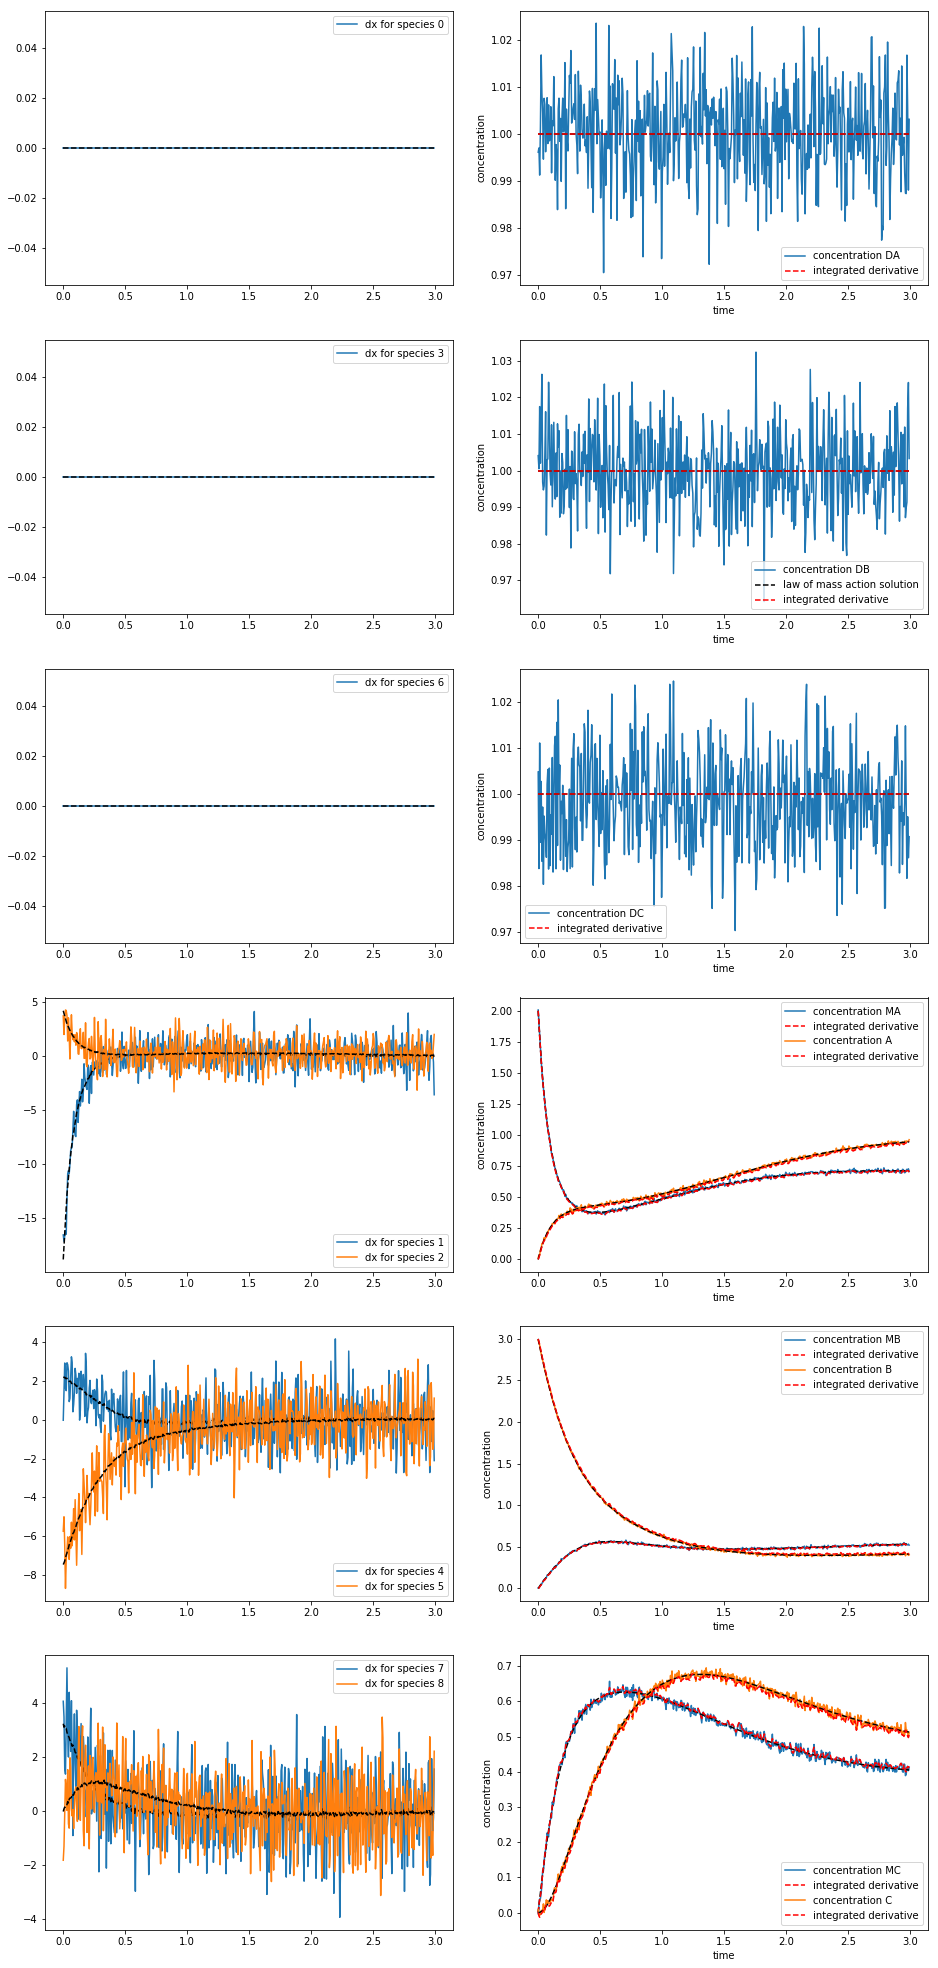

In [6]:
regulation_network.plot_concentrations(analysis, 1)

In [7]:
#alphas = np.concatenate((
#        np.linspace(0.000001,0.0001,num=16),
#        np.linspace(0.0002,0.012,num=16),
#        np.linspace(0.012,0.1,num=8)))
alphas = np.logspace(-6., 0., num=10)
l1_ratios = np.linspace(0., 1., num=3)

In [8]:
cv_res = analysis.elastic_net_cv([i for i in range(4)], alphas=alphas, l1_ratios=l1_ratios, 
                                 recompute=False, tol=1e-12)

In [9]:
cv_res.result

array([{'scores': [-4.2247428063540005], 'alpha': 1e-06, 'l1_ratio': 0.0, 'train_trajs': array([1, 2, 3]), 'test_trajs': array([0])},
       {'scores': [-4.224742196335108], 'alpha': 1e-06, 'l1_ratio': 0.5, 'train_trajs': array([1, 2, 3]), 'test_trajs': array([0])},
       {'scores': [-4.149971590092382], 'alpha': 1e-06, 'l1_ratio': 0.5, 'train_trajs': array([0, 2, 3]), 'test_trajs': array([1])},
       {'scores': [-4.149990869641191], 'alpha': 1e-06, 'l1_ratio': 0.0, 'train_trajs': array([0, 2, 3]), 'test_trajs': array([1])},
       {'scores': [-4.94790122250775], 'alpha': 1e-06, 'l1_ratio': 0.5, 'train_trajs': array([0, 1, 3]), 'test_trajs': array([2])},
       {'scores': [-5.961521786233579], 'alpha': 1e-06, 'l1_ratio': 0.5, 'train_trajs': array([0, 1, 2]), 'test_trajs': array([3])},
       {'scores': [-4.948335913282896], 'alpha': 1e-06, 'l1_ratio': 0.0, 'train_trajs': array([0, 1, 3]), 'test_trajs': array([2])},
       {'scores': [-5.959811140296538], 'alpha': 1e-06, 'l1_ratio': 0

In [10]:
def cluster_along_arg(samples, arg_key, arg_values):
    """
    Transform list of samples into a dictionary that maps 
    from arg_value (described by arg_key) to the clustered 
    samples list.
    """
    clustered_samples = dict()
    for arg_value in arg_values:
        clustered_samples[arg_value] = []
    
    for sample in samples:
        for arg_value in arg_values:
            if sample[arg_key] == arg_value:
                clustered_samples[arg_value].append(sample)
    
    return clustered_samples

[ -4.82072018  -4.8187816   -4.80936035  -4.77547031  -4.68222547
  -4.61712256  -5.26602113  -7.0417473   -8.90313108 -10.11899519]
[ -4.8210342   -4.81942486  -4.81252109  -4.78293986  -4.6899754
  -4.52260703  -4.85468914  -6.83980403  -9.70986042 -10.48208794]
[ -4.82118809  -4.82027742  -4.81575805  -4.79550955  -4.70933123
  -4.37062927  -4.32485141  -5.829225    -9.82404953 -10.42041265]


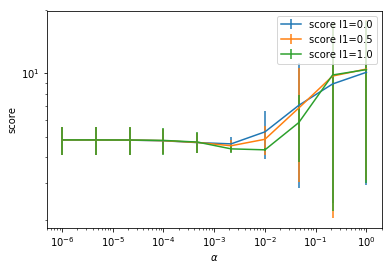

In [11]:
def plot_cv_results2(cv):
    l1_dict = cluster_along_arg(cv.result, "l1_ratio", cv.l1_ratios)
    alphas_dict = {}
    for l1_ratio in l1_dict.keys():
        alphas_dict[l1_ratio] = cluster_along_arg(l1_dict[l1_ratio], "alpha", cv.alphas)
        
    for l1_ratio in l1_dict.keys():
        scores_mean = []
        scores_err = []
        for alpha in alphas:
            cv_data = alphas_dict[l1_ratio][alpha]
            scores = []
            for d in cv_data:
                scores.append(d['scores'][0])
            scores = np.array(scores)
            scores_mean.append(np.mean(scores))
            scores_err.append(np.std(scores))
        scores_mean = np.array(scores_mean)
        scores_err = np.array(scores_err)
        print(scores_mean)
        plt.errorbar(alphas, -scores_mean, yerr=scores_err, label='score l1={}'.format(l1_ratio))
    
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
plot_cv_results2(cv_res)

In [17]:
alpha, l1_ratio, score = best_params(cv_res)
print("got alpha={}, l1_ratio={}, score={}".format(alpha, l1_ratio, score))

-4.820720182393656
-4.818781603468547
-4.809360345998685
-4.775470311210405
-4.682225466584349
-4.617122560641617
-5.266021127814572
-7.0417473008892655
-8.903131081991603
-10.118995186350261
-4.821034198792205
-4.819424862994307
-4.812521087997055
-4.782939860870325
-4.68997540090512
-4.522607025388415
-4.854689137570128
-6.839804027554307
-9.709860419832673
-10.482087938674667
-4.82118809112092
-4.820277421911152
-4.815758048817913
-4.795509550508102
-4.709331232497969
-4.370629272218432
-4.324851414021966
-5.829224997671256
-9.824049531174229
-10.420412646210407
got alpha=0.01, l1_ratio=1.0, score=4.324851414021966


In [18]:
rates = analysis.solve([i for i in range(4)], alpha, l1_ratio, tol=1e-14)

optimization problem did exit successfully (alpha=0.01, lambda=1.0)!
status 0: Optimization terminated successfully.
106 / 30000 iterations


In [19]:
l1_norm = sum([abs(r) for r in regulation_network.desired_rates])
print("L1 norm of desired rates = {}".format(l1_norm))
alpha = 7.6e-06
print("L1 norm * alpha = {}".format(alpha * l1_norm))

L1 norm of desired rates = 39.400000000000006
L1 norm * alpha = 0.00029944000000000005


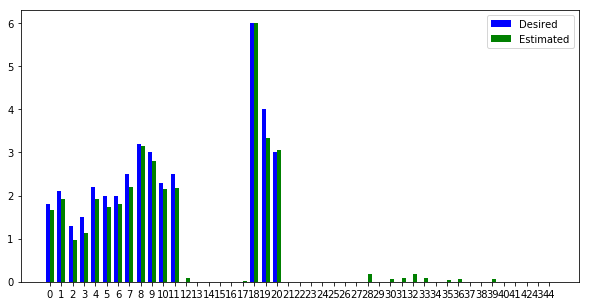

In [20]:
ana.plot_rates_bar(regulation_network.desired_rates, rates)
#plt.title("L1 regularization")

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
130 / 30000 iterations


Text(0.5,1,'Least-squares')

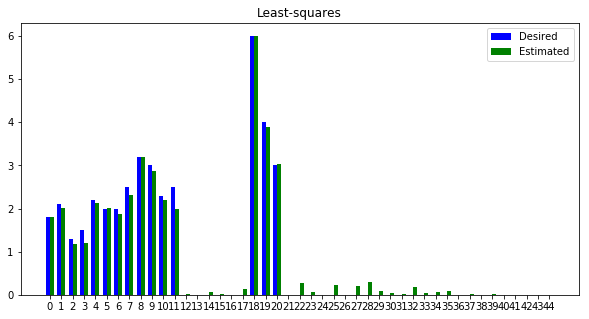

In [21]:
lsq_rates = analysis.least_squares([0, 1, 2, 3], tol=1e-14, recompute=True)
ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
plt.title("Least-squares")

In [22]:
lsq_rates - rates

array([ 1.39363361e-01,  1.02150503e-01,  2.08438412e-01,  6.15906120e-02,
        2.04749969e-01,  2.73889234e-01,  6.20600661e-02,  1.17164824e-01,
        4.79569128e-02,  7.00531105e-02,  4.40340707e-02, -1.67125238e-01,
       -6.88077030e-02,  1.85225162e-18,  6.86012824e-02,  2.25401876e-02,
       -1.23289259e-17,  1.37285038e-01, -1.26527708e-02,  5.55296078e-01,
       -1.47100932e-02, -1.18840212e-17,  2.69106550e-01,  6.86012824e-02,
        1.56569207e-17,  2.32707092e-01, -3.19352430e-18,  2.04963191e-01,
        1.30376394e-01,  9.18247928e-02, -1.75274465e-02, -5.98759856e-02,
        1.34866862e-02, -5.83517932e-02,  6.04179573e-02,  3.62270092e-02,
       -6.02124713e-02,  2.80417641e-02, -3.95562920e-18, -5.52410669e-02,
       -8.41548325e-18,  0.00000000e+00, -8.89048946e-18,  0.00000000e+00,
       -1.69853883e-17])

In [23]:
np.sum(rates)

36.85613812592592

In [24]:
np.sum(lsq_rates)

39.59255993900135

In [25]:
np.sum(regulation_network.desired_rates)

39.400000000000006

# ESTRATES

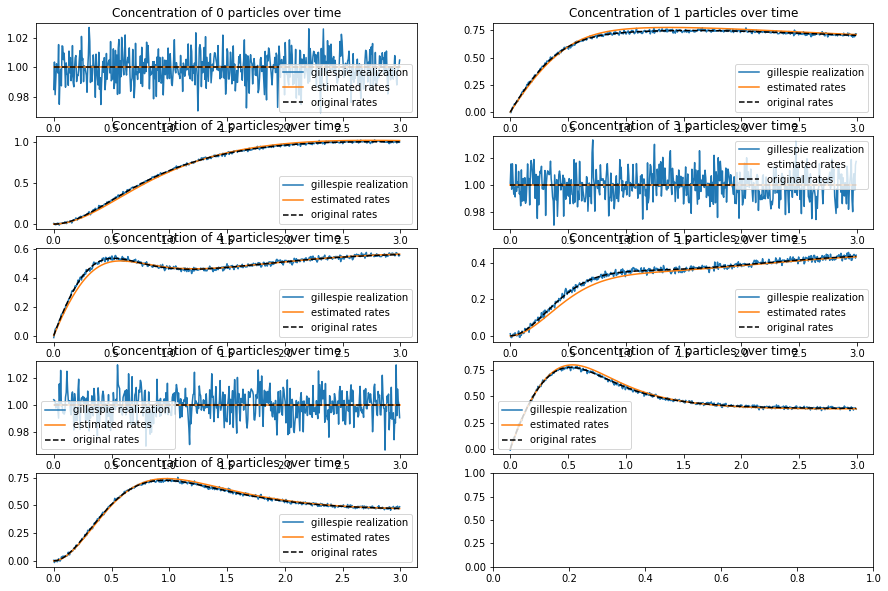

In [29]:
analysis.plot_results(0, rates)

# LSQ

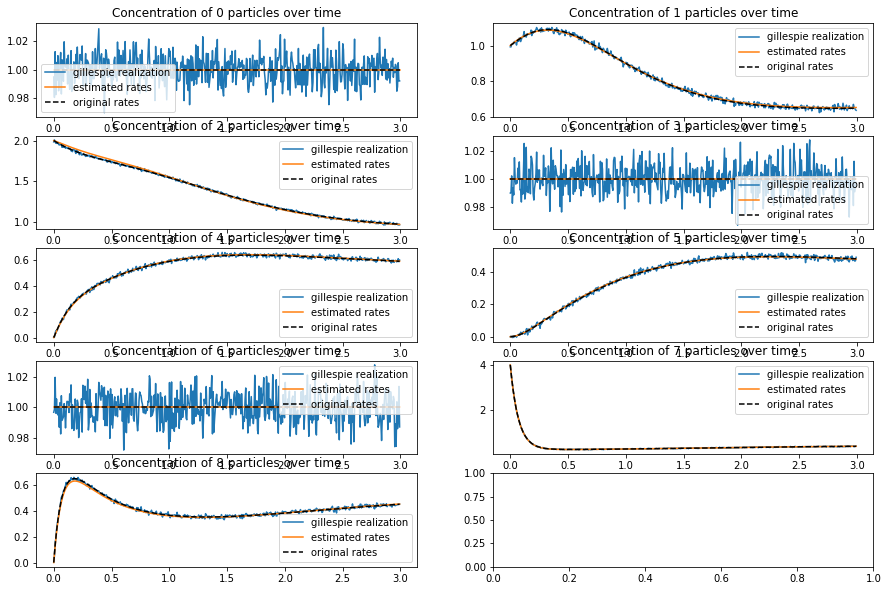

In [33]:
analysis.plot_results(3, lsq_rates)

## save result

In [24]:
if noise_variance>0.:
    est_rates_path = os.path.join("simple_gradient", "est_rates_for_"+str(realisations)+".npy")
    cv_results_path = os.path.join("simple_gradient", "cv_results_for_"+str(realisations)+".pickle")
else:
    est_rates_path = os.path.join("simple_gradient", "est_rates_for_infty.npy")
    cv_results_path = os.path.join("simple_gradient", "cv_results_for_infty.pickle")

np.save(est_rates_path, est_rates)
with open(cv_results_path, "wb") as file:
    pickle.dump(cv_res, file, protocol=pickle.HIGHEST_PROTOCOL)